In [86]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
from matplotlib import rcParams
import datetime
from scipy.stats import norm, kstest, sem
from numpy.polynomial import polynomial

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import OverlapCounterROI

In [107]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/"
master_csv = data_dir + 'scnn1a-ppr.csv'
###################################
# Process paired-pulse ratio data
#    - IPIs are shuffled, open <slice>_<loc>shuffle.txt for IPI order
#    - extract Amplitude, half_width, latency for pulse 1 and pulse 2 for each ROI
#    - ROIs are in order (in file "<slice>_barrel_rois.dat" for each date subdir):
#          -  medial -> lateral if available
#          - otherwise, in some order that preserves neighbors (1,2 are neighbors and 2,3 are neighbors)
#    - which barrel is home barrel (stimulated) is recorded in master csv scnn1a-ppr.csv for each loc
###################################
enable_photoZ_interact = False
initialize_photoZ = True
disable_trace_export = True  # if True, don't export traces, only save arrays

snr_cutoff_signal = 0
amp_cutoff = 2

In [88]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()
    # normalization needs to be off since we are saving arrays
    aPhz.click_normalize_2_array_max()

In [89]:
# load master csv file for metadata
master_df = pd.read_csv(master_csv)
master_df = pd.DataFrame(master_df)
master_df

,Date,Slice_Loc,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel
0,12/8/2023,3_2,up,L2/3,Caudal,2
1,12/8/2023,4_1,NaN,L4,Rostral,2
2,12/8/2023,5_1,NaN,L4,Rostral,1
3,12/8/2023,5_2,NaN,L4,Rostral,2
4,12/8/2023,6_1,NaN,L4,NaN,1
5,12/8/2023,6_2,NaN,L4,NaN,2
6,12/13/2023,1_4,NaN,L2/3,Rostral,1
7,12/13/2023,2_1,NaN,L4,Rostral,1
8,12/13/2023,3_1,NaN,L4,Caudal,2
9,12/13/2023,3_2,NaN,L2/3,Caudal,2


In [90]:
def get_shuffle_filename(slic, loc):
    return str(slic) + "_" + str(loc) + "shuffle.txt"

def get_barrel_roi_filename(slic):
    return str(slic) + "_barrel_rois.dat"

# locate all files
data_map = {}
for subdir, dirs, files in os.walk(data_dir):
    if 'hidden' in subdir:
        continue
    if not ('dic' in dirs and 'selected_zda' in dirs):
        continue
    print("\n", subdir)
    dic_dir = subdir + "/dic/"
    selected_zda_dir = subdir + "/selected_zda/"
    data_map[subdir] = {}
    for zda_file in os.listdir(selected_zda_dir):
        if zda_file.endswith('.zda'):
            slr_id = zda_file.split('.')[0]
            slic_id, loc_id, rec_id = [int(x) for x in slr_id.split("_")]
            print(slic_id, loc_id, rec_id)
            if slic_id not in data_map[subdir]:
                # find ROI file and index it
                data_map[subdir][slic_id] = {'roi_file': subdir + "/" + get_barrel_roi_filename(slic_id)}
            if loc_id not in data_map[subdir][slic_id]:
                # find shuffle file and index it
                data_map[subdir][slic_id][loc_id] = {'zda_files': [],
                                                     'shuffle_file': subdir + "/" +  get_shuffle_filename(slic_id, loc_id)}
            data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)  # appends in ascending order


 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23
3 2 2
3 2 3
3 2 4
3 2 5
3 2 6
3 2 7
3 2 8
3 2 9
3 2 10
3 2 11
3 2 12
3 2 13
3 2 14
3 2 15
3 2 16
3 2 17
4 1 1
4 1 2
4 1 3
4 1 4
4 1 5
4 1 6
4 1 7
4 1 8
4 1 9
4 1 10
4 1 11
4 1 12
4 1 13
4 1 14
4 1 15
4 1 16
5 1 2
5 1 3
5 1 4
5 1 5
5 1 6
5 1 7
5 1 8
5 1 9
5 1 10
5 1 11
5 1 12
5 1 13
5 1 14
5 1 15
5 1 16
5 1 17
5 2 2
5 2 3
5 2 4
5 2 5
5 2 6
5 2 7
5 2 8
5 2 9
5 2 10
5 2 11
5 2 12
5 2 13
5 2 14
5 2 15
5 2 16
5 2 17
6 1 4
6 1 5
6 1 6
6 1 7
6 1 8
6 1 9
6 1 10
6 1 11
6 1 12
6 1 13
6 1 14
6 1 15
6 1 16
6 1 17
6 1 18
6 1 19
6 2 1
6 2 2
6 2 3
6 2 4
6 2 5
6 2 6
6 2 7
6 2 8
6 2 9
6 2 10
6 2 11
6 2 12
6 2 13
6 2 14
6 2 15
6 2 16

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-13-23
1 4 2
1 4 3
1 4 4
1 4 5
1 4 6
1 4 7
1 4 8
1 4 9
1 4 10
1 4 11
1 4 12
1 4 13
1 4 14
1 4 15
1 4 16
1 4 17
2 1 1
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
2 1 16
3 1 2
3 1 3
3 1

In [91]:
# go through the IPIs in their shuffled order (ascending recordings) 
# and extract Amplitude, half_width, latency for pulse 1 and pulse 2 for each ROI
copy_enable_photoZ_interact = enable_photoZ_interact
enable_photoZ_interact = not disable_trace_export

for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    print(subdir)
    for slic_id in data_map[subdir]:

        # open roi_file for whole slice
        if enable_photoZ_interact:
            roi_file = data_map[subdir][slic_id]['roi_file']
            aPhz.select_roi_tab()
            aPhz.open_roi_file(roi_file)

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [int(x) for x in lines]
            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)
                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                for i_pulse in [1, 2]:
                    if enable_photoZ_interact:
                        measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                        aPhz.set_measure_window(measure_window_start, None)

                        # change polynomial skip window too to match measure window
                        aPhz.set_polynomial_skip_window(measure_window_start)

                    # take Amplitude, half_width, latency and label which pulse
                    # save SNR values from PhotoZ
                    snr_filename = subdir + "/" + "SNR_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                    if enable_photoZ_interact:
                        aPhz.select_SNR_trace_value()
                        aPhz.save_trace_values(snr_filename)

                    # save half-width values from PhotoZ
                    hw_filename = subdir + "/" + "hw_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat" 
                    if enable_photoZ_interact:
                        aPhz.select_half_width_trace_value()
                        aPhz.save_trace_values(hw_filename)

                    # save amp values from PhotoZ
                    amp_filename = subdir + "/" + "amp_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                    if enable_photoZ_interact:
                        aPhz.select_maxamp_trace_value()
                        aPhz.save_trace_values(amp_filename)
                        
                    # save latency values from PhotoZ
                    lat_filename = subdir + "/" + "lat_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                    if enable_photoZ_interact:
                        aPhz.select_latency_trace_value()
                        aPhz.save_trace_values(lat_filename)


                    if ipi not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][ipi] = {}
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse] = {'amp': amp_filename,
                                                                       'hw': hw_filename,
                                                                       'snr': snr_filename,
                                                                       'lat': lat_filename}
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)
enable_photoZ_interact = copy_enable_photoZ_interact  

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23
3 2 IPI: 10 ms for recording 03_02_02.zda
3 2 IPI: 20 ms for recording 03_02_03.zda
3 2 IPI: 30 ms for recording 03_02_04.zda
3 2 IPI: 40 ms for recording 03_02_05.zda
3 2 IPI: 50 ms for recording 03_02_06.zda
3 2 IPI: 60 ms for recording 03_02_07.zda
3 2 IPI: 70 ms for recording 03_02_08.zda
3 2 IPI: 80 ms for recording 03_02_09.zda
3 2 IPI: 90 ms for recording 03_02_10.zda
3 2 IPI: 100 ms for recording 03_02_11.zda
3 2 IPI: 110 ms for recording 03_02_12.zda
3 2 IPI: 120 ms for recording 03_02_13.zda
3 2 IPI: 130 ms for recording 03_02_14.zda
3 2 IPI: 140 ms for recording 03_02_15.zda
3 2 IPI: 150 ms for recording 03_02_16.zda
3 2 IPI: 5 ms for recording 03_02_17.zda
4 1 IPI: 5 ms for recording 04_01_01.zda
4 1 IPI: 10 ms for recording 04_01_02.zda
4 1 IPI: 20 ms for recording 04_01_03.zda
4 1 IPI: 30 ms for recording 04_01_04.zda
4 1 IPI: 40 ms for recording 04_01_05.zda
4 1 IPI: 50 ms for recording 04_01_06.z

IPI: 60 ms for recording 04_01_09.zda
4 1 IPI: 80 ms for recording 04_01_10.zda
4 1 IPI: 120 ms for recording 04_01_11.zda
4 1 IPI: 130 ms for recording 04_01_12.zda
4 1 IPI: 110 ms for recording 04_01_13.zda
4 1 IPI: 140 ms for recording 04_01_14.zda
4 1 IPI: 90 ms for recording 04_01_15.zda
4 1 IPI: 100 ms for recording 04_01_16.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-14-23
1 3 IPI: 5 ms for recording 01_03_01.zda
1 3 IPI: 120 ms for recording 01_03_02.zda
1 3 IPI: 150 ms for recording 01_03_03.zda
1 3 IPI: 130 ms for recording 01_03_04.zda
1 3 IPI: 50 ms for recording 01_03_05.zda
1 3 IPI: 80 ms for recording 01_03_06.zda
1 3 IPI: 90 ms for recording 01_03_07.zda
1 3 IPI: 110 ms for recording 01_03_08.zda
1 3 IPI: 40 ms for recording 01_03_09.zda
1 3 IPI: 140 ms for recording 01_03_10.zda
1 3 IPI: 70 ms for recording 01_03_11.zda
1 3 IPI: 60 ms for recording 01_03_12.zda
1 3 IPI: 100 ms for recording 01_03_13.zda
1 3 IPI: 20 ms for recording 01_03_14

In [92]:
# Also extract actual pulse admin times for pulse 1 and pulse 2
if enable_photoZ_interact:
    pa.alert("Make sure the only trace selected is analog input from stimulator")
latency_selected =  False
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    if not latency_selected and enable_photoZ_interact:
        latency_selected = True
        aPhz.select_latency_trace_value()
    print(subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [int(x) for x in lines]
            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)
                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                for i_pulse in [1, 2]:
                    if enable_photoZ_interact:
                        measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                        aPhz.set_measure_window(measure_window_start, None)

                        # change polynomial skip window too to match measure window
                        aPhz.set_polynomial_skip_window(measure_window_start)
                    
                    # save pulse admin times
                    pa_filename = subdir + "/" + "pa_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['pa'] = pa_filename

                    if enable_photoZ_interact:
                        aPhz.save_trace_values(pa_filename)
                        print("\t Saved file", pa_filename)

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23
3 2 IPI: 10 ms for recording 03_02_02.zda
3 2 IPI: 20 ms for recording 03_02_03.zda
3 2 IPI: 30 ms for recording 03_02_04.zda
3 2 IPI: 40 ms for recording 03_02_05.zda
3 2 IPI: 50 ms for recording 03_02_06.zda
3 2 IPI: 60 ms for recording 03_02_07.zda
3 2 IPI: 70 ms for recording 03_02_08.zda
3 2 IPI: 80 ms for recording 03_02_09.zda
3 2 IPI: 90 ms for recording 03_02_10.zda
3 2 IPI: 100 ms for recording 03_02_11.zda
3 2 IPI: 110 ms for recording 03_02_12.zda
3 2 IPI: 120 ms for recording 03_02_13.zda
3 2 IPI: 130 ms for recording 03_02_14.zda
3 2 IPI: 140 ms for recording 03_02_15.zda
3 2 IPI: 150 ms for recording 03_02_16.zda
3 2 IPI: 5 ms for recording 03_02_17.zda
4 1 IPI: 5 ms for recording 04_01_01.zda
4 1 IPI: 10 ms for recording 04_01_02.zda
4 1 IPI: 20 ms for recording 04_01_03.zda
4 1 IPI: 30 ms for recording 04_01_04.zda
4 1 IPI: 40 ms for recording 04_01_05.zda
4 1 IPI: 50 ms for recording 04_01_06.z

In [103]:
# load all these amp, hw, snr, lat into a dataframe
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['ROI',  'Value'])
    return data_arr

snr_dfs = []
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            for ipi in data_map[subdir][slic_id][loc_id]:
                if type(ipi) == str:
                    continue
                for i_pulse in data_map[subdir][slic_id][loc_id][ipi]:
                    dm = data_map[subdir][slic_id][loc_id][ipi][i_pulse]
                    
                    try:
                        amp = read_dat_trace_file(dm['amp'])
                        hw = read_dat_trace_file(dm['hw'])
                        snr = read_dat_trace_file(dm['snr'])
                        lat = read_dat_trace_file(dm['lat'])
                        actual_stim = read_dat_trace_file(dm['pa'])  # will be 2 values per pulse per recording, broadcast to all ROIs
                    except Exception as e:
                        print(e)
                        continue
                    actual_stim = actual_stim['Value'].item()
                    snr = snr.join(amp, rsuffix='_amp')
                    snr = snr.join(hw, rsuffix='_hw')
                    snr = snr.join(lat, rsuffix='_lat')
                    snr.insert(4, 'Pulse', [i_pulse for _ in range(len(snr['ROI']))])
                    snr.insert(5, 'IPI', [ipi for _ in range(len(snr['ROI']))])
                    snr.insert(6, 'Medial Dir', [medial_dir for _ in range(len(snr['ROI']))])
                    snr.insert(7, 'Stim Layer', [stim_layer for _ in range(len(snr['ROI']))])
                    snr.insert(8, 'Caudal/Rostral', [caudal_rostral for _ in range(len(snr['ROI']))])
                    snr.insert(9, 'Home Barrel', [home_barrel for _ in range(len(snr['ROI']))])
                    snr.insert(10, 'Date', [date for _ in range(len(snr['ROI']))])
                    snr.insert(11, 'Slice_Loc', [slic_loc_id for _ in range(len(snr['ROI']))])
                    snr.insert(12, "Actual Stim", [actual_stim for _ in range(len(snr['ROI']))])
                    snr = snr[pd.to_numeric(snr.Value, errors='coerce').notnull()]
                    snr_dfs.append(snr)
        
pre_filter_snr = pd.concat(snr_dfs)
pre_filter_snr = pre_filter_snr[['Date', 'Slice_Loc', 'ROI', 'Value', 'Value_amp', 'Value_hw', 
                                 'Value_lat', 'Pulse', 'IPI',
                                 'Medial Dir', 'Stim Layer', 'Caudal/Rostral', 'Home Barrel', 'Actual Stim']]

# correct Latency for actual stim time
pre_filter_snr['Value_lat'] = pre_filter_snr['Value_lat'] - pre_filter_snr['Actual Stim']

pre_filter_snr = pre_filter_snr.rename(columns={'Value': "SNR",
                                                'Value_amp': "Amp", 
                                                'Value_hw' : "Halfwidth", 
                                                'Value_lat': "Latency"})
pre_filter_snr["Amp"] = pd.to_numeric(pre_filter_snr["Amp"])
pre_filter_snr['PPR'] = ''
pre_filter_snr

,Date,Slice_Loc,ROI,SNR,Amp,Halfwidth,Latency,Pulse,IPI,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,Actual Stim,PPR
0,12/8/2023,3_2,1,1.792070,0.301058,-104.79500,3.9982,1,10,up,L2/3,Caudal,2,48.4505,
1,12/8/2023,3_2,2,4.903530,0.312345,5.67150,3.1406,1,10,up,L2/3,Caudal,2,48.4505,
2,12/8/2023,3_2,3,1.835520,0.306782,-104.42200,3.8114,1,10,up,L2/3,Caudal,2,48.4505,
0,12/8/2023,3_2,1,1.775360,0.926149,7.76580,0.2688,2,10,up,L2/3,Caudal,2,59.8083,
1,12/8/2023,3_2,2,4.051870,1.837380,4.46569,1.7628,2,10,up,L2/3,Caudal,2,59.8083,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,12/19/2023,4_1,2,5.464650,0.483628,6.71430,0.3957,2,30,NaN,L4,Rostral,2,79.8034,
0,12/19/2023,4_1,1,0.910626,0.043237,1.53890,5.3485,1,20,NaN,L4,Rostral,2,48.3528,
1,12/19/2023,4_1,2,3.893600,0.373637,4.81526,1.4755,1,20,NaN,L4,Rostral,2,48.3528,
0,12/19/2023,4_1,1,2.101880,0.096144,4.08306,0.4435,2,20,NaN,L4,Rostral,2,69.8077,


In [128]:
# Now compute PPR = Amp(pulse 2) / Amp(pulse 1). 
for date in pre_filter_snr['Date'].unique():
    pfs_date = pre_filter_snr[pre_filter_snr["Date"] == date]
    for slic_loc in pfs_date['Slice_Loc'].unique():
        pfs_sl = pfs_date[pfs_date["Slice_Loc"] == slic_loc]
        for roi in pfs_sl['ROI'].unique():
            pfs_roi = pfs_sl[pfs_sl['ROI'] == roi]
            for ipi in pfs_roi['IPI'].unique():
                pfs_ipi = pfs_roi[pfs_roi['IPI'] == ipi]
                assert len(pfs_ipi) == 2  # should always be exactly 2 (otherwise can't compute PPR)

                amp1 = pfs_ipi[pfs_ipi['Pulse'] == 1]['Amp'].item()
                lat1 = pfs_ipi[pfs_ipi['Pulse'] == 1]['Latency'].item()
                hw1 = pfs_ipi[pfs_ipi['Pulse'] == 1]['Halfwidth'].item()

                # Compute PPR = Amp(pulse 2) / Amp(pulse 1)
                ppr = None
                if amp1 != 0:
                    amp2 = pfs_ipi[pfs_ipi['Pulse'] == 2]['Amp'].item()
                    ppr = amp2 / amp1
                if ppr is not None and 0 < ppr < 2:
                    pre_filter_snr.loc[(pre_filter_snr['Date'] == date) &
                                   (pre_filter_snr['Slice_Loc'] == slic_loc) &
                                   (pre_filter_snr['ROI'] == roi) & 
                                   (pre_filter_snr['IPI'] == ipi), 
                                       'PPR'] = ppr
                
                # Compute PPL = Latency(pulse 2) / Latency(pulse 1)
                ppl = None
                if lat1 != 0:
                    lat2 = pfs_ipi[pfs_ipi['Pulse'] == 2]['Latency'].item()
                    ppl = lat2 / lat1
                if ppl is not None and 0 < ppl:
                    pre_filter_snr.loc[(pre_filter_snr['Date'] == date) &
                                   (pre_filter_snr['Slice_Loc'] == slic_loc) &
                                   (pre_filter_snr['ROI'] == roi) & 
                                   (pre_filter_snr['IPI'] == ipi), 
                                       'PPL'] = ppl
                    
                # Compute PPHW = Halfwidth(pulse 2) / Halfwidth(pulse 1)
                pphw = None
                if hw1 != 0:
                    hw2 = pfs_ipi[pfs_ipi['Pulse'] == 2]['Halfwidth'].item()
                    pphw = hw2 / hw1
                if pphw is not None and 0 < pphw:
                    pre_filter_snr.loc[(pre_filter_snr['Date'] == date) &
                                   (pre_filter_snr['Slice_Loc'] == slic_loc) &
                                   (pre_filter_snr['ROI'] == roi) & 
                                   (pre_filter_snr['IPI'] == ipi), 
                                       'PPHW'] = pphw

pre_filter_snr["PPR"] = pd.to_numeric(pre_filter_snr["PPR"])
pre_filter_snr["PPL"] = pd.to_numeric(pre_filter_snr["PPL"])
pre_filter_snr["PPHW"] = pd.to_numeric(pre_filter_snr["PPHW"])
# write to csv
csv_filename = 'scnn1a-ppr-output.csv'
pre_filter_snr.to_csv(data_dir + csv_filename, index=False)

# now some filtering
all_snr = pre_filter_snr[pre_filter_snr['SNR'] > snr_cutoff_signal]
all_snr = all_snr[all_snr['Halfwidth'] > 0]
all_snr = all_snr[all_snr['Halfwidth'] < 15]
all_snr = all_snr[all_snr['Latency'] < 15]
all_snr = all_snr[all_snr['Latency'] > 0]
all_snr = all_snr[all_snr['Amp'] > amp_cutoff]
all_snr = all_snr[all_snr['IPI'] < 150]  # 150 ms IPI cannot be measured properly with this setup
#all_snr = all_snr[all_snr['Date'] != '12/8/2023']  # exclude due to faulty baseline correction

all_snr

,Date,Slice_Loc,ROI,SNR,Amp,Halfwidth,Latency,Pulse,IPI,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,Actual Stim,PPR,PPL,PPHW
1,12/8/2023,3_2,2,5.27212,2.46748,4.47188,3.1563,1,20,up,L2/3,Caudal,2,48.4439,0.758644,0.815892,0.852114
1,12/8/2023,3_2,2,5.43864,2.66691,5.44523,3.1951,1,30,up,L2/3,Caudal,2,48.3476,0.616852,0.891021,0.653385
1,12/8/2023,3_2,2,5.60122,2.70548,5.09992,3.0578,1,40,up,L2/3,Caudal,2,48.5474,0.662600,0.949310,0.683699
1,12/8/2023,3_2,2,5.48550,2.87610,5.19859,3.2336,1,50,up,L2/3,Caudal,2,48.3428,0.629731,0.921110,0.644102
1,12/8/2023,3_2,2,5.47581,3.00279,5.67457,3.1891,1,60,up,L2/3,Caudal,2,48.4366,0.583807,0.962340,0.702125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,12/18/2023,4_2,3,34.45340,5.53395,6.26901,3.0371,1,50,down,L2/3,Caudal,3,48.4598,0.670098,0.858846,0.688388
1,12/18/2023,4_2,2,9.67300,2.76617,5.55976,2.8944,2,50,down,L2/3,Caudal,3,99.7936,0.836032,0.842448,NaN
2,12/18/2023,4_2,3,13.48420,3.70829,4.31551,2.6084,2,50,down,L2/3,Caudal,3,99.7936,0.670098,0.858846,0.688388
2,12/18/2023,4_2,3,19.78160,5.40980,6.18566,3.0741,1,130,down,L2/3,Caudal,3,48.5064,0.902856,0.892944,0.860654


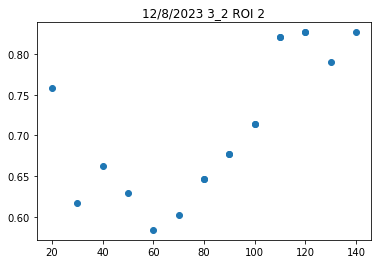

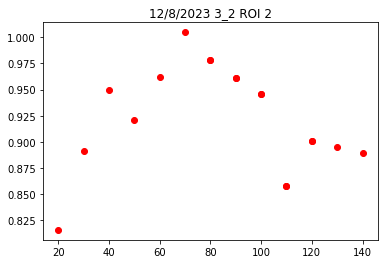

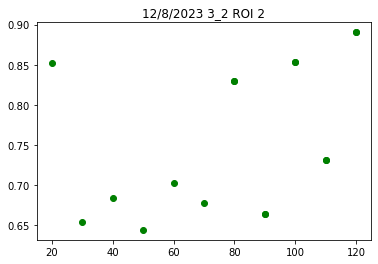

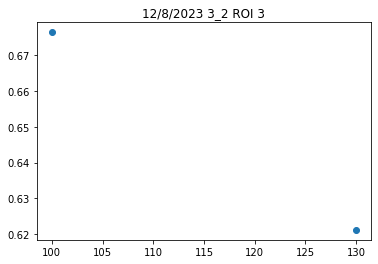

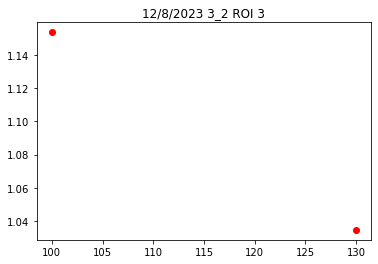

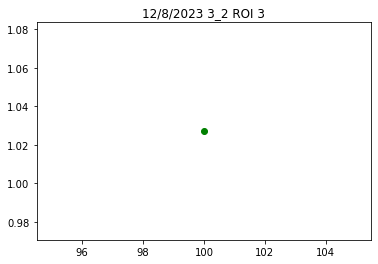

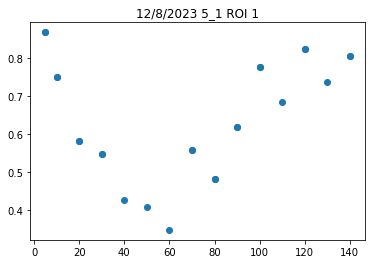

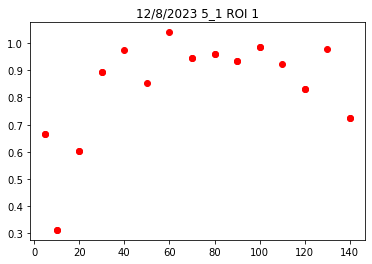

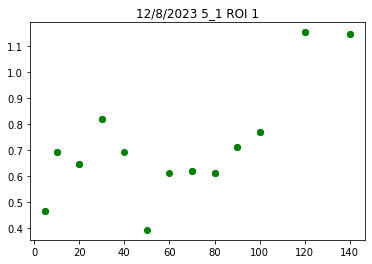

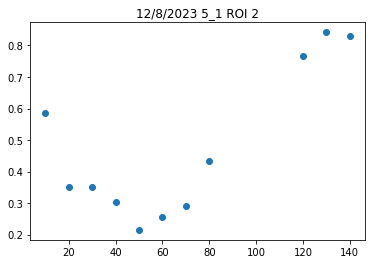

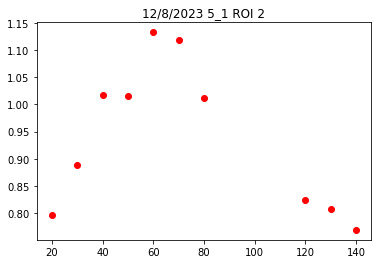

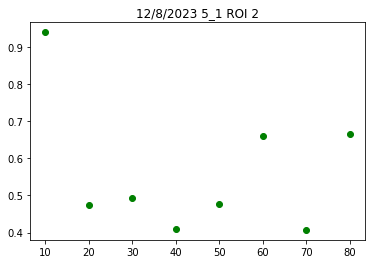

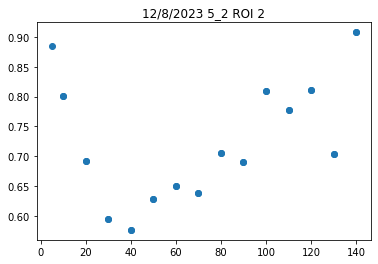

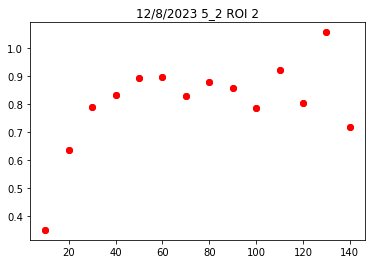

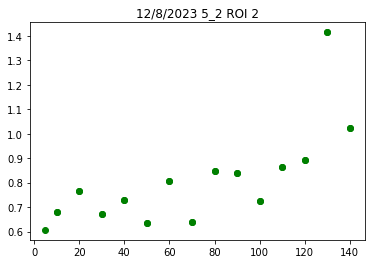

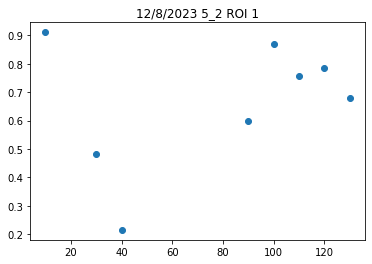

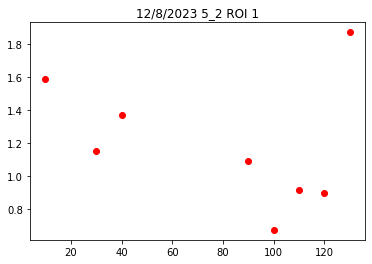

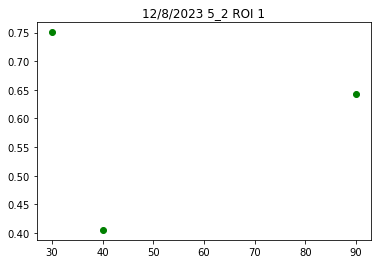

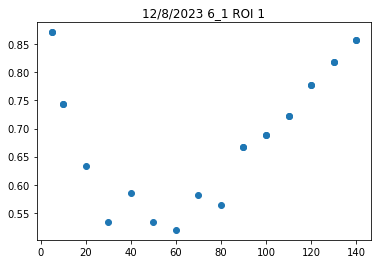

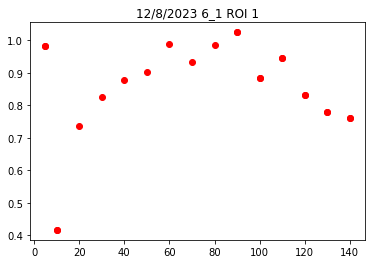

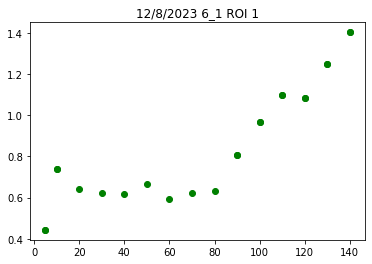

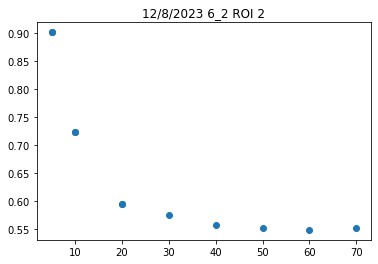

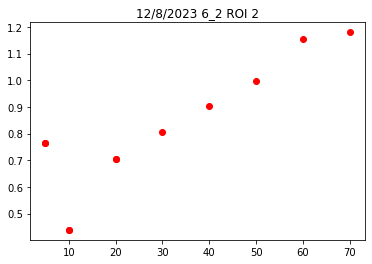

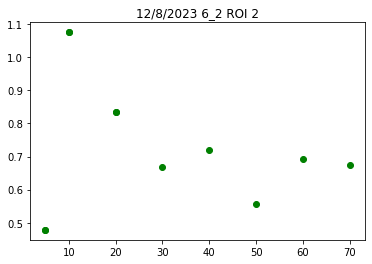

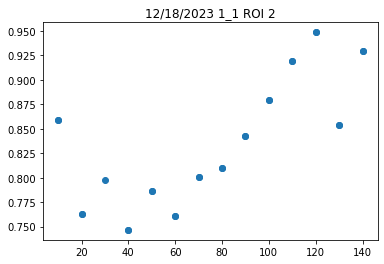

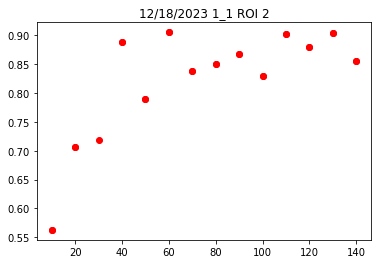

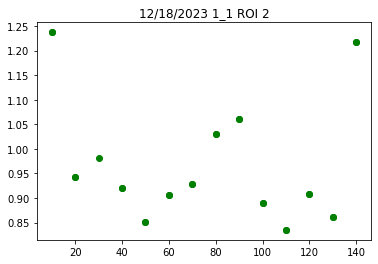

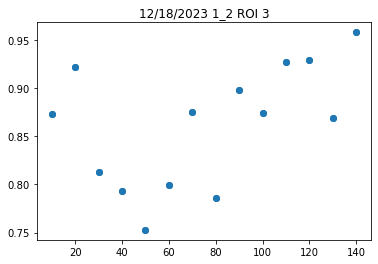

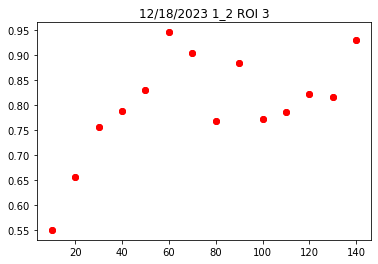

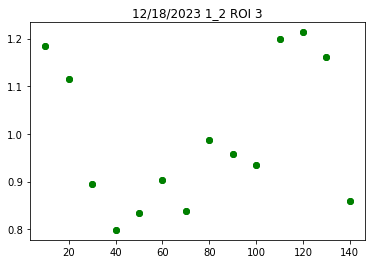

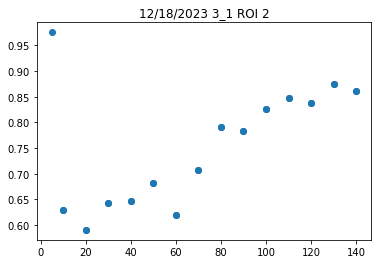

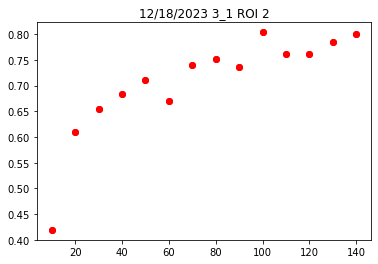

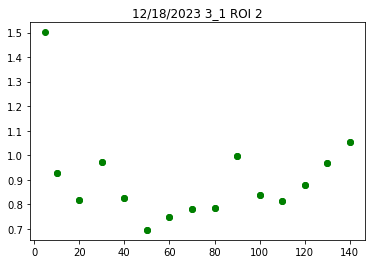

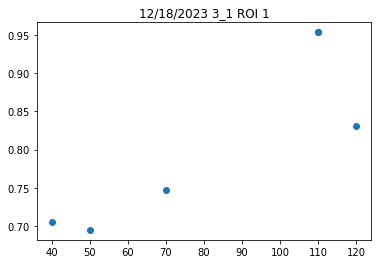

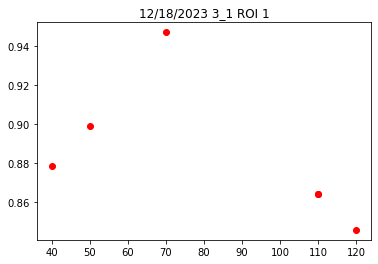

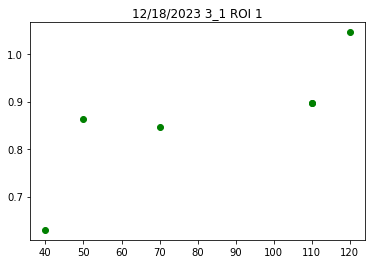

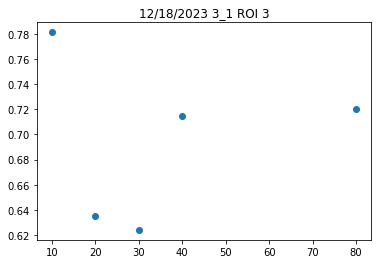

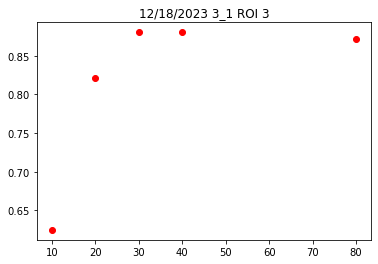

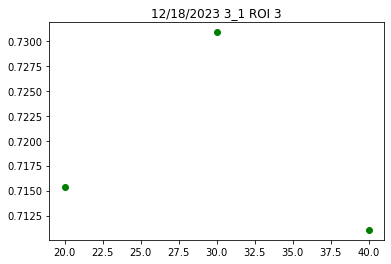

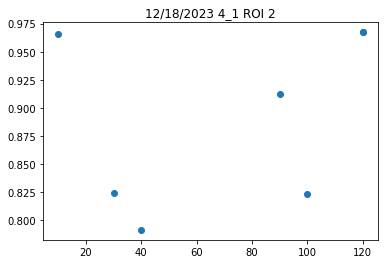

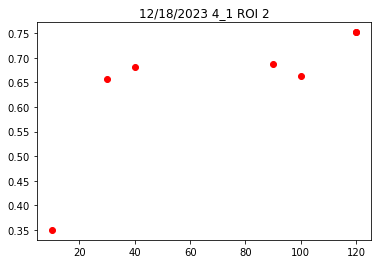

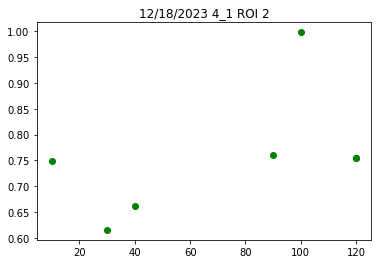

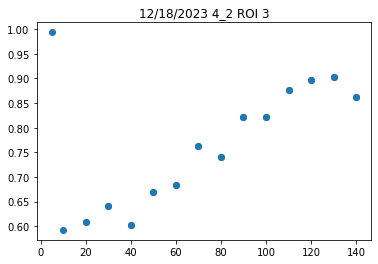

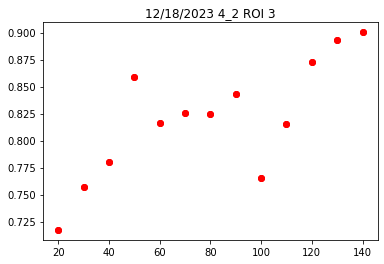

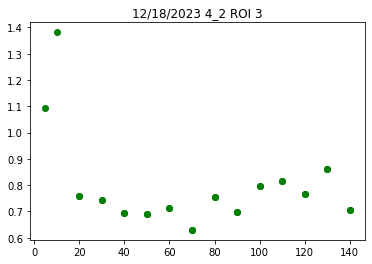

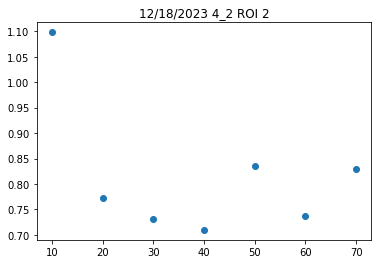

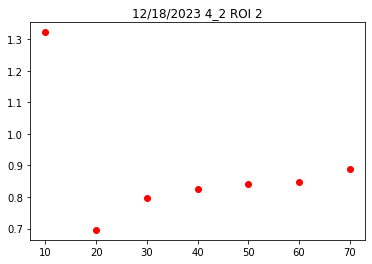

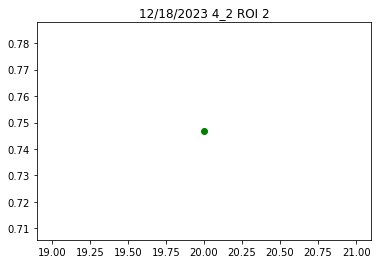

In [129]:
# for each date, slice/loc, and ROI, plot PPR vs IPI
for date in all_snr['Date'].unique():
    pfs_date = all_snr[all_snr["Date"] == date]
    for slic_loc in pfs_date['Slice_Loc'].unique():
        pfs_sl = pfs_date[pfs_date["Slice_Loc"] == slic_loc]
        for roi in pfs_sl['ROI'].unique():
            pfs_roi = pfs_sl[pfs_sl['ROI'] == roi]
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPR'])
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPL'], c='r')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPHW'], c='g')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()

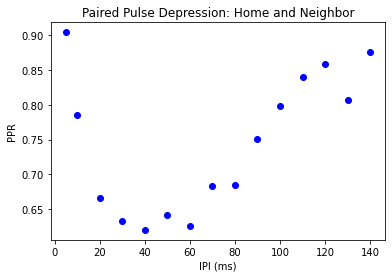

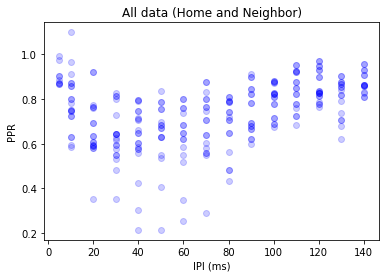

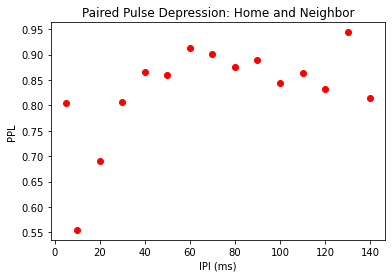

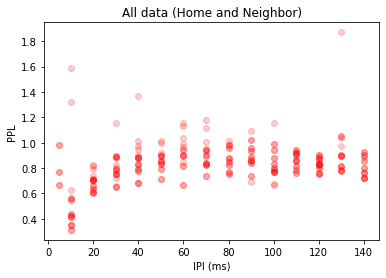

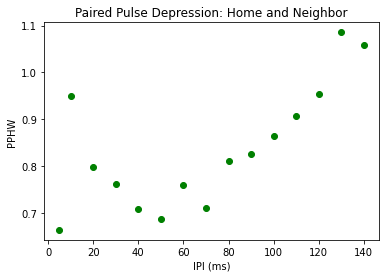

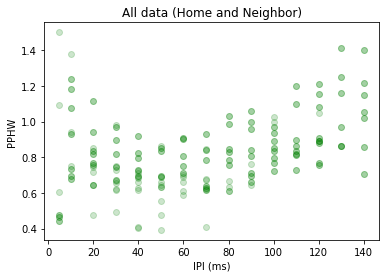

In [130]:
# average grouping by IPI
for pp_type, color in [['PPR', 'b'], ['PPL', 'r'], ['PPHW', 'g']]:
    group_by_ipi = all_snr[['IPI', pp_type]].groupby(by=['IPI']).mean()
    group_by_ipi_std = all_snr[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std)
    group_by_ipi.reset_index(inplace=True)

    # plot average PPR vs IPI
    plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
    plt.title("Paired Pulse Depression: Home and Neighbor")
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.show()
    plt.scatter(all_snr['IPI'], all_snr[pp_type], alpha=0.2, c=color)
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.title("All data (Home and Neighbor)")
    plt.show()

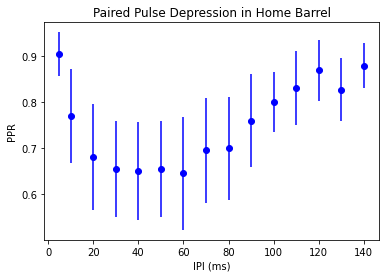

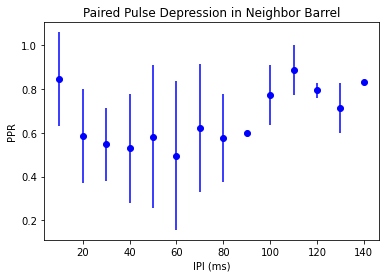

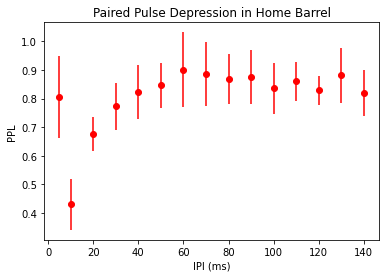

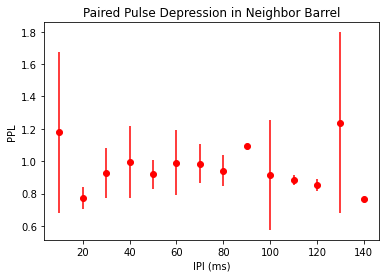

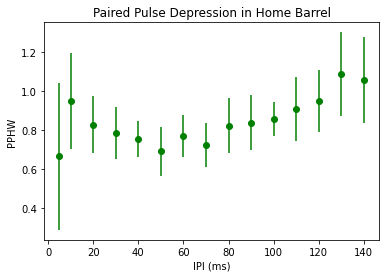

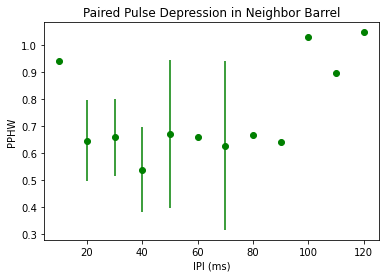

In [131]:
# home barrel or neighboring barrel
home_barrel_df = all_snr.query('`Home Barrel` == ROI')
neighbor_barrel_df = all_snr.query('`Home Barrel` != ROI')
titles = ['Home Barrel', 'Neighbor Barrel']
for pp_type, color in [['PPR', 'b'], ['PPL', 'r'], ['PPHW', 'g']]:
    i = 0
    for barrel_df in [home_barrel_df, neighbor_barrel_df]:
        group_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).mean()
        group_by_ipi_std = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std)
        group_by_ipi.reset_index(inplace=True)
        plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
        plt.errorbar(group_by_ipi['IPI'], group_by_ipi[pp_type], 
                     group_by_ipi_std[pp_type], ls='none', c=color)
        plt.title("Paired Pulse Depression in " + titles[i])
        plt.xlabel("IPI (ms)")
        plt.ylabel(pp_type)
        plt.show()
        i += 1

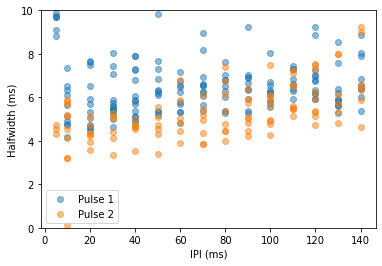

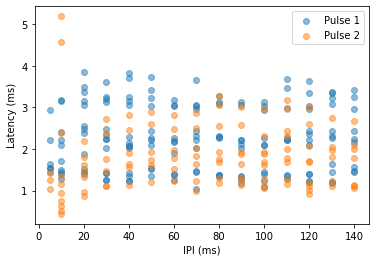

In [132]:
# check for pulse 1 vs pulse 2 changes in latency or halfwidth
pulse1_df = all_snr.query('Pulse == 1')
pulse2_df = all_snr.query('Pulse == 2')
titles = ['Pulse 1', 'Pulse 2']
i = 0
for pulse_df in [pulse1_df, pulse2_df]:
    plt.scatter(pulse_df['IPI'], pulse_df['Halfwidth'], alpha=0.5, label=titles[i])
    # plt.title("Halfwidth")
    plt.xlabel("IPI (ms)")
    plt.ylabel("Halfwidth (ms)")
    plt.ylim([0, 10])
    plt.legend()
    i += 1
plt.show()

i = 0
for pulse_df in [pulse1_df, pulse2_df]:
    plt.scatter(pulse_df['IPI'], pulse_df['Latency'], alpha=0.5, label=titles[i])
    # plt.title("Latency for " + titles[i])
    plt.xlabel("IPI (ms)")
    plt.ylabel("Latency (ms)")
    plt.legend()
    i += 1
plt.show()

In [133]:
# autoPhotoZ to save amplitude arrays for each measure window and baseline correction to create PPR maps
def get_amp_array_filename(subdir, slic_loc_id, ipi, pulse):
    return subdir + "/" + "ampArray_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(pulse) + ".dat"

def get_hw_array_filename(subdir, slic_loc_id, ipi, pulse):
    return subdir + "/" + "hwArray_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(pulse) + ".dat"

def get_lat_array_filename(subdir, slic_loc_id, ipi, pulse):
    return subdir + "/" + "latArray_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(pulse) + ".dat"

overwrite_amp_arrays = False
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
        
    print(subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [int(x) for x in lines]

            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:

                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])

                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)

                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    hw_array_filename = get_hw_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    lat_array_filename = get_lat_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if enable_photoZ_interact:
                        measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                        aPhz.set_measure_window(measure_window_start, None)

                        # change polynomial skip window too to match measure window
                        aPhz.set_polynomial_skip_window(measure_window_start)

                    # take Amplitude array from PhotoZ
                    if enable_photoZ_interact and overwrite_amp_arrays:
                        aPhz.select_MaxAmp_array()
                        aPhz.save_background(filename=amp_array_filename)
                        print("\t Saved file", amp_array_filename)

                    # take Half-width array from PhotoZ
                    if enable_photoZ_interact:
                        aPhz.select_HalfWidth_array()
                        aPhz.save_background(filename=hw_array_filename)
                        print("\t Saved file", hw_array_filename)

                    # take Latency array from PhotoZ
                    if enable_photoZ_interact:
                        aPhz.select_Latency_array()
                        aPhz.save_background(filename=lat_array_filename)
                        print("\t Saved file", lat_array_filename)

                    if ipi not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][ipi] = {}
                    if i_pulse not in data_map[subdir][slic_id][loc_id][ipi]:
                        data_map[subdir][slic_id][loc_id][ipi][i_pulse] = {}
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['amp_array'] = amp_array_filename
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['hw_array'] = hw_array_filename
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['lat_array'] = lat_array_filename
                    
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)
                        

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23
3 2 IPI: 10 ms for recording 03_02_02.zda
3 2 IPI: 20 ms for recording 03_02_03.zda
3 2 IPI: 30 ms for recording 03_02_04.zda
3 2 IPI: 40 ms for recording 03_02_05.zda
3 2 IPI: 50 ms for recording 03_02_06.zda
3 2 IPI: 60 ms for recording 03_02_07.zda
3 2 IPI: 70 ms for recording 03_02_08.zda
3 2 IPI: 80 ms for recording 03_02_09.zda
3 2 IPI: 90 ms for recording 03_02_10.zda
3 2 IPI: 100 ms for recording 03_02_11.zda
3 2 IPI: 110 ms for recording 03_02_12.zda
3 2 IPI: 120 ms for recording 03_02_13.zda
3 2 IPI: 130 ms for recording 03_02_14.zda
3 2 IPI: 140 ms for recording 03_02_15.zda
3 2 IPI: 150 ms for recording 03_02_16.zda
3 2 IPI: 5 ms for recording 03_02_17.zda
4 1 IPI: 5 ms for recording 04_01_01.zda
4 1 IPI: 10 ms for recording 04_01_02.zda
4 1 IPI: 20 ms for recording 04_01_03.zda
4 1 IPI: 30 ms for recording 04_01_04.zda
4 1 IPI: 40 ms for recording 04_01_05.zda
4 1 IPI: 50 ms for recording 04_01_06.z

<ipython-input-100-1e6b105dea48>:45: RuntimeWarning: divide by zero encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1
<ipython-input-100-1e6b105dea48>:45: RuntimeWarning: invalid value encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1


[0.9837332917546671, 0.9852445425357768, 0.9885151524817728, 0.9760219638298145, 0.8152402933929938, 0.8241942067957534, 0.81819454777416, 0.826703475100286, 0.7840731643894862, 0.7654149674275726, 0.7842861119302413, 0.9700301499336647, 0.969918149545399, 0.8547286199218893, 0.8050105537629506, 0.7764527780378545, 0.758371215535781, 0.760785660571039, 0.8070897015071675, 0.8575974325456496, 0.8784272736838413, 0.8791222738522504, 0.9705777249980637, 0.9686885836007784, 0.9697932594819617, 0.9703874017366285, 0.9709177731337912, 0.9694482972184562, 0.9673051348278624, 0.9196422166364481, 0.8650298489195916, 0.8503032241708621, 0.8582348232154771, 0.8628879601418643, 0.8525373593227348, 0.8552557609150323, 0.8741368559932653, 0.8557423562582943, 0.8737781573548897, 0.9692196920775813, 0.9695216754503462, 0.968876009737411, 0.9704493278022309, 0.9695353466577773, 0.9688157692110262, 0.9670350107100273, 0.953805835821822, 0.8808444642307495, 0.8615979926763321, 0.9000232292329337, 0.90402

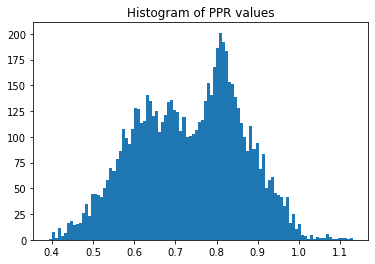

In [100]:
# use amp arrays of both pulses to create PPR maps of different IPIs of the recordings 
def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr

ppr_hist = []
pphw_hist = []
ppl_hist = []
# load in amp array files into dataframe for each IPI
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            for ipi in data_map[subdir][slic_id][loc_id]:

                if type(ipi) == str:
                    continue
                
                # load amp files as numpy arrays using np.loadtxt
                amp_arr1 = get_amp_array_filename(subdir, slic_loc_id, ipi, 1)
                amp_arr2 = get_amp_array_filename(subdir, slic_loc_id, ipi, 2)
                amp_arr1 = read_dat_arr_file(amp_arr1)
                amp_arr2 = read_dat_arr_file(amp_arr2)
                ppr_map = amp_arr2 / amp_arr1
                # build histogram of PPR values for pixels above cutoff
                for i in range(amp_arr1.shape[0]):
                    for j in range(amp_arr1.shape[1]):
                        if amp_arr1[i, j] > amp_cutoff and 0 < ppr_map[i, j] < 2 and amp_arr2[i, j] != amp_arr1[i, j]:
                            ppr_hist.append(ppr_map[i, j])

                # load hw files as numpy arrays using np.loadtxt
                hw_arr1 = get_hw_array_filename(subdir, slic_loc_id, ipi, 1)
                hw_arr2 = get_hw_array_filename(subdir, slic_loc_id, ipi, 2)
                hw_arr1 = read_dat_arr_file(hw_arr1)
                hw_arr2 = read_dat_arr_file(hw_arr2)
                pphw_map = amp_arr2 / amp_arr1
                # build histogram of PPHW values for pixels above cutoff
                for i in range(hw_arr1.shape[0]):
                    for j in range(hw_arr1.shape[1]):
                        if amp_arr1[i, j] > amp_cutoff and 0 < pphw_map[i, j] and hw_arr2[i, j] != hw_arr1[i, j]:
                            ppr_hist.append(pphw_map[i, j])

                # load lat files as numpy arrays using np.loadtxt
                lat_arr1 = get_lat_array_filename(subdir, slic_loc_id, ipi, 1)
                lat_arr2 = get_lat_array_filename(subdir, slic_loc_id, ipi, 2)
                lat_arr1 = read_dat_arr_file(lat_arr1)
                lat_arr2 = read_dat_arr_file(lat_arr2)
                ppl_map = lat_arr2 / lat_arr1
                # build histogram of PPL values for pixels above cutoff
                for i in range(lat_arr1.shape[0]):
                    for j in range(lat_arr1.shape[1]):
                        if amp_arr1[i, j] > amp_cutoff and 0 < ppl_map[i, j] and lat_arr2[i, j] != lat_arr1[i, j]:
                            ppr_hist.append(ppl_map[i, j])

# plot histogram of PPR values
plt.hist(ppr_hist, bins=100, color='b')
plt.title("Histogram of PPR values")
plt.show()

# plot histogram of PPHW values
plt.hist(pphw_hist, bins=100, color='g')
plt.title("Histogram of PPHW values")
plt.show()

# plot histogram of PPL values
plt.hist(ppl_hist, bins=100, color='r')
plt.title("Histogram of PPL values")
plt.show()

